# Training and Evaluation Pipeline

This notebook implements the training and evaluation of different machine learning models for classification.

## Pipeline Structure:
1. **Library Imports**
2. **Loading Processed Data**
3. **Hyperparameter Optimization**
4. **Model Evaluation and Comparison**
5. **Best Model Selection**

## 1. Library Imports

Import all necessary libraries for model training and evaluation:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

## 2. Loading Processed Data

Load the datasets that were processed in the previous notebook:

In [2]:
print("--- Loading prepared datasets ---")
train_df = pd.read_csv('train_dataset.csv')
val_df = pd.read_csv('validation_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

# Combine training and validation for GridSearchCV
full_train_df = pd.concat([train_df, val_df])
X_train = full_train_df.drop('target', axis=1)
y_train = full_train_df['target']
X_test = test_df.drop('target', axis=1)
y_test = test_df['target']

# Load label encoder to get class names
label_encoder = joblib.load('label_encoder.joblib')
target_names = label_encoder.classes_

print(f"Training data: {X_train.shape}")
print(f"Test data: {X_test.shape}")
print(f"Classes: {target_names}")

# Dictionaries to store best models and results
best_models = {}
results = {}

--- Loading prepared datasets ---
Training data: (675, 27)
Test data: (75, 27)
Classes: ['Fim de Jogo' 'Possibilidade de Fim' 'Tem Jogo']


## 3. Hyperparameter Optimization

### 3.1 k-Nearest Neighbors (k-NN)

In [3]:
print("\n--- Optimizing k-NN ---")
param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_knn.fit(X_train, y_train)
best_models['k-NN'] = grid_knn.best_estimator_
print(f"Best parameters: {grid_knn.best_params_}")


--- Optimizing k-NN ---
Best parameters: {'n_neighbors': 7, 'weights': 'distance'}
Best parameters: {'n_neighbors': 7, 'weights': 'distance'}


### 3.2 Árvore de Decisão

In [4]:
print("\n--- Optimizing Decision Tree ---")
param_grid_dt = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, None], 'min_samples_leaf': [1, 2, 4]}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_dt.fit(X_train, y_train)
best_models['Decision Tree'] = grid_dt.best_estimator_
print(f"Best parameters: {grid_dt.best_params_}")


--- Optimizing Decision Tree ---
Best parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1}


### 3.3 Multi-layer Perceptron (MLP)

In [5]:
print("\n--- Optimizing MLP ---")
param_grid_mlp = {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'activation': ['relu', 'tanh'], 'max_iter': [1000]}
grid_mlp = GridSearchCV(MLPClassifier(random_state=42), param_grid_mlp, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_mlp.fit(X_train, y_train)
best_models['MLP'] = grid_mlp.best_estimator_
print(f"Best parameters: {grid_mlp.best_params_}")


--- Optimizing MLP ---
Best parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50), 'max_iter': 1000}
Best parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50), 'max_iter': 1000}


### 3.4 Random Forest

In [6]:
print("\n--- Optimizing Random Forest ---")
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_leaf': [1, 2]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_models['Random Forest'] = grid_rf.best_estimator_
print(f"Best parameters: {grid_rf.best_params_}")


--- Optimizing Random Forest ---
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}


### 3.5 Support Vector Machine (SVM)

In [7]:
print("\n--- Optimizing SVM ---")
param_grid_svm = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf', 'poly']}
grid_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_svm.fit(X_train, y_train)
best_models['SVM'] = grid_svm.best_estimator_
print(f"Best parameters: {grid_svm.best_params_}")


--- Optimizing SVM ---
Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


## 4. Model Evaluation on Test Set

Evaluate all optimized models on the test set:

In [8]:
print("\n\n--- Final Evaluation of Optimized Models on Test Set ---")

for name, model in best_models.items():
    print(f"\n--- Report for: {name} ---")
    y_pred = model.predict(X_test)
    
    # Print complete classification report
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    # Save weighted F1-Score for final comparison
    results[name] = f1_score(y_test, y_pred, average='weighted')



--- Final Evaluation of Optimized Models on Test Set ---

--- Report for: k-NN ---
                      precision    recall  f1-score   support

         Fim de Jogo       0.89      0.96      0.92        25
Possibilidade de Fim       0.78      0.56      0.65        25
            Tem Jogo       0.73      0.88      0.80        25

            accuracy                           0.80        75
           macro avg       0.80      0.80      0.79        75
        weighted avg       0.80      0.80      0.79        75


--- Report for: Decision Tree ---
                      precision    recall  f1-score   support

         Fim de Jogo       0.70      0.76      0.73        25
Possibilidade de Fim       0.52      0.48      0.50        25
            Tem Jogo       0.68      0.68      0.68        25

            accuracy                           0.64        75
           macro avg       0.64      0.64      0.64        75
        weighted avg       0.64      0.64      0.64        75


--- R

## 5. Results Comparison and Visualization

Create a comparative table and visualize model performance:



--- Performance Comparison Table ---
           Model  F1-Score (Weighted)
0            MLP             0.865196
1            SVM             0.863903
2           k-NN             0.791413
3  Random Forest             0.771005
4  Decision Tree             0.636923


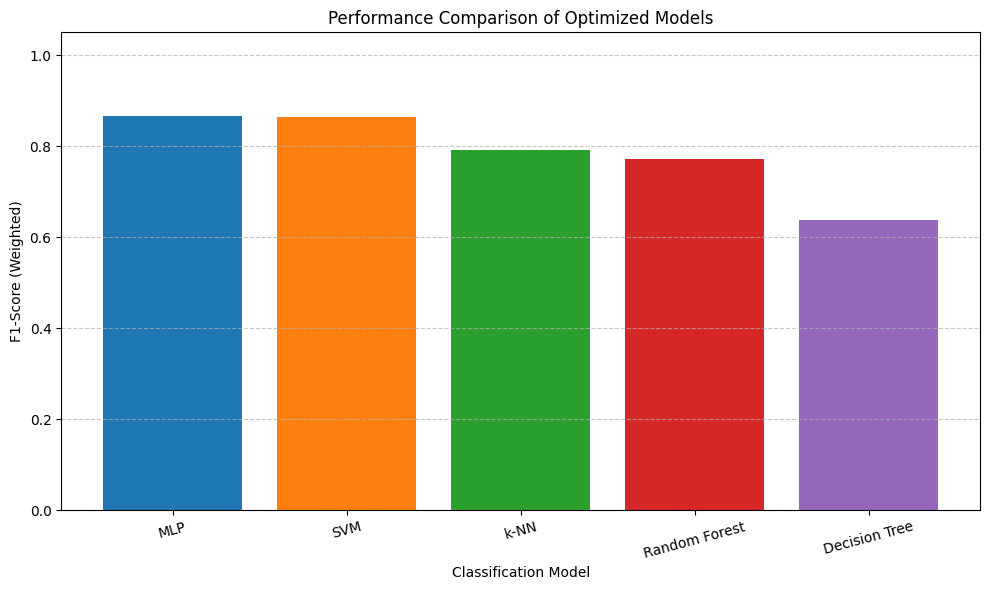

In [9]:
# Create comparative results table
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'F1-Score (Weighted)'])
results_df = results_df.sort_values(by='F1-Score (Weighted)', ascending=False).reset_index(drop=True)

print("\n\n--- Performance Comparison Table ---")
print(results_df)

# Create bar chart for visualization
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['F1-Score (Weighted)'], 
        color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.xlabel('Classification Model')
plt.ylabel('F1-Score (Weighted)')
plt.title('Performance Comparison of Optimized Models')
plt.ylim(0, 1.05)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

## 6. Best Model Selection and Saving

Select the best performing model and save it for future use:

In [10]:
# Select best model based on F1-Score
best_model_name = results_df.loc[0, 'Model']
best_model_object = best_models[best_model_name]

print(f"\n🏆 Based on F1-Score, the best model for this problem is: {best_model_name}")
print(f"Best model F1-Score: {results_df.loc[0, 'F1-Score (Weighted)']:.4f}")

# Save the best model
print("Saving model to 'best_classifier.joblib'...")
joblib.dump(best_model_object, 'best_classifier.joblib')
print("Model saved successfully! Ready to be used in the game.")


🏆 Based on F1-Score, the best model for this problem is: MLP
Best model F1-Score: 0.8652
Saving model to 'best_classifier.joblib'...
Model saved successfully! Ready to be used in the game.
